In [1]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

In [2]:
monthly_pA = pd.read_csv('Resources/monthly_pA.csv',index_col=False)
monthly_pB = pd.read_csv('Resources/monthly_pB.csv',index_col=False)
monthly_pD = pd.read_csv('Resources/monthly_pD.csv',index_col=False)
chemicals = pd.read_csv('Resources/chemicals_raw.csv',index_col=False)
chemicals.head()

,year_month,cA,cB,cCD,production,cA_per_prod,cB_per_prod,cCD_per_prod
0,200901,50533.0,17100,22500.0,630494,0.080148,0.027122,0.035686
1,200902,37659.0,25650,22500.0,412244,0.084577,0.040998,0.043156
2,200903,47330.0,19950,15000.0,464256,0.089929,0.041606,0.039814
3,200904,45100.0,14250,22500.0,483255,0.095671,0.044015,0.044126
4,200905,31538.0,8550,15000.0,289430,0.100221,0.034561,0.042443


In [3]:
# Merge respective chemical usage and production for each process output
monthly_pA = monthly_pA.merge(chemicals,on='year_month').drop(columns=['cB','cCD','cB_per_prod','cCD_per_prod'])
monthly_pB = monthly_pB.merge(chemicals,on='year_month').drop(columns=['cA','cCD','cA_per_prod','cCD_per_prod'])
monthly_pD = monthly_pD.merge(chemicals,on='year_month').drop(columns=['cA','cB','cA_per_prod','cB_per_prod'])

In [4]:
# monthly_pB has some 0 values in cB, will remove these as they cause skewed residuals
# There is also a clear difference since ~2017 than in previous years for cB usage
monthly_pB = monthly_pB[monthly_pB['cB']!=0].reset_index(drop=True)
monthly_pB_full = monthly_pB
# monthly_pB_reg = monthly_pB.drop(monthly_pB[(monthly_pB.year_month > 201907) & (monthly_pB.year_month < 201911)].index).reset_index(drop=True)
monthly_pB = monthly_pB[monthly_pB['year_month'] > 201612].reset_index(drop=True)

In [5]:
# Get a datetime column for each dataframe
from datetime import datetime
monthly_pA['year_month'] = monthly_pA['year_month'].astype(str)
datetime_list = []
for i in range(len(monthly_pA)):
    datetime_list.append(datetime.strptime(monthly_pA['year_month'][i],'%Y%m'))
monthly_pA['datetime'] = datetime_list
monthly_pA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 0 to 134
Data columns (total 11 columns):
year_month               135 non-null object
average_exhaustion       135 non-null float64
average_sA               135 non-null float64
number_extract_points    135 non-null float64
average_pA               135 non-null float64
Predicted_pA             135 non-null float64
Error                    135 non-null float64
datetime                 135 non-null datetime64[ns]
cA                       135 non-null float64
production               135 non-null int64
cA_per_prod              135 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 17.7+ KB


In [6]:
monthly_pB['year_month'] = monthly_pB['year_month'].astype(str)
datetime_list = []
for i in range(len(monthly_pB)):
    datetime_list.append(datetime.strptime(monthly_pB['year_month'][i],'%Y%m'))
monthly_pB['datetime'] = datetime_list
monthly_pB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 11 columns):
year_month               29 non-null object
average_exhaustion       29 non-null float64
average_sA               29 non-null float64
number_extract_points    29 non-null float64
average_pB               29 non-null float64
Predicted_pB             29 non-null float64
Error                    29 non-null float64
datetime                 29 non-null datetime64[ns]
cB                       29 non-null int64
production               29 non-null int64
cB_per_prod              29 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 2.6+ KB


In [7]:
monthly_pB_full['year_month'] = monthly_pB_full['year_month'].astype(str)
datetime_list = []
for i in range(len(monthly_pB_full)):
    datetime_list.append(datetime.strptime(monthly_pB_full['year_month'][i],'%Y%m'))
monthly_pB_full['datetime'] = datetime_list
monthly_pB_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 11 columns):
year_month               113 non-null object
average_exhaustion       113 non-null float64
average_sA               113 non-null float64
number_extract_points    113 non-null float64
average_pB               113 non-null float64
Predicted_pB             113 non-null float64
Error                    113 non-null float64
datetime                 113 non-null datetime64[ns]
cB                       113 non-null int64
production               113 non-null int64
cB_per_prod              113 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 9.8+ KB


In [8]:
monthly_pD['year_month'] = monthly_pD['year_month'].astype(str)
datetime_list = []
for i in range(len(monthly_pD)):
    datetime_list.append(datetime.strptime(monthly_pD['year_month'][i],'%Y%m'))
monthly_pD['datetime'] = datetime_list
monthly_pD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 0 to 127
Data columns (total 11 columns):
year_month               128 non-null object
average_exhaustion       128 non-null float64
average_sA               128 non-null float64
number_extract_points    128 non-null float64
average_pD               128 non-null float64
Predicted_pD             128 non-null float64
Error                    128 non-null float64
datetime                 128 non-null datetime64[ns]
cCD                      128 non-null float64
production               128 non-null int64
cCD_per_prod             128 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 17.0+ KB


In [9]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [10]:
# Plot chemical usage per production vs pA,pB,pD - if there is a good correlation, predicted values can
# be used and the source features do not need to be used in two sets of models

In [11]:
##########################
# pA Testing Starts Here #
##########################

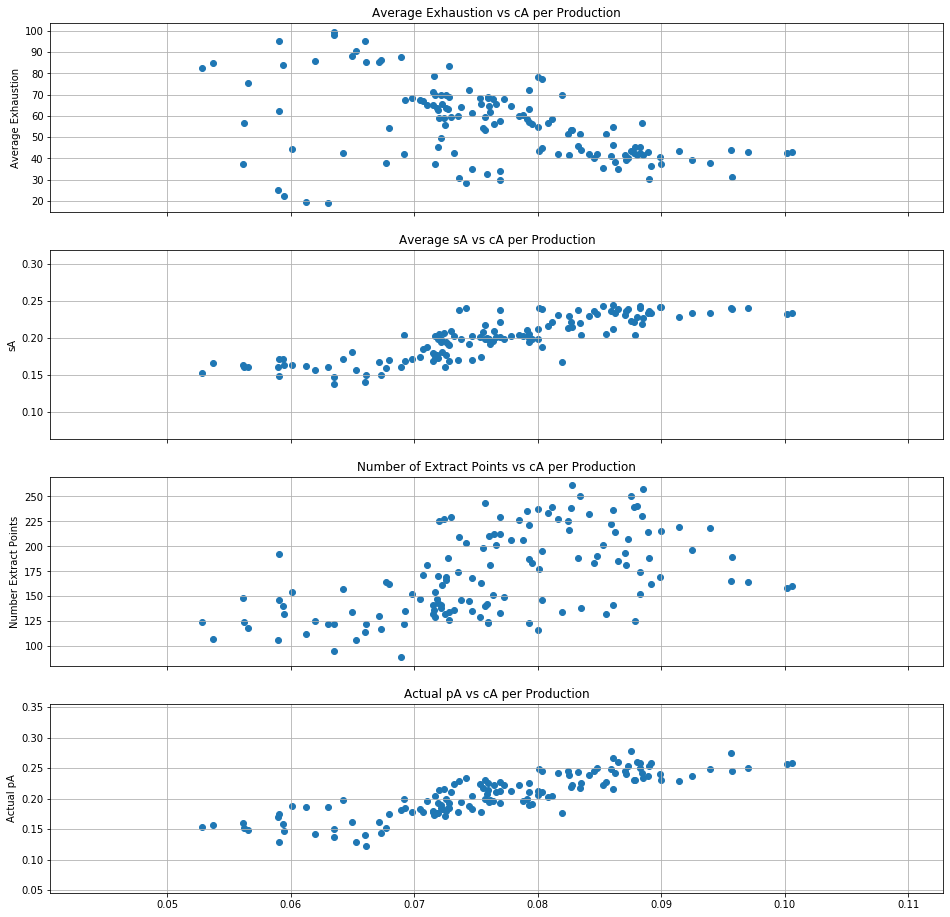

In [12]:
# Scatter plots to visualize possible relationships
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,sharex=True)
ax1.scatter(monthly_pA['cA_per_prod'],monthly_pA['average_exhaustion'])
ax1.set_ylabel('Average Exhaustion')
ax1.grid(True)
ax1.set_title('Average Exhaustion vs cA per Production')
ax2.scatter(monthly_pA['cA_per_prod'],monthly_pA['average_sA'])
ax2.set_ylabel('sA')
ax2.grid(True)
ax2.set_title('Average sA vs cA per Production')
ax3.scatter(monthly_pA['cA_per_prod'],monthly_pA['number_extract_points'])
ax3.set_ylabel('Number Extract Points')
ax3.grid(True)
ax3.set_title('Number of Extract Points vs cA per Production')
ax4.scatter(monthly_pA['cA_per_prod'],monthly_pA['average_pA'])
ax4.set_ylabel('Actual pA')
ax4.grid(True)
ax4.set_title('Actual pA vs cA per Production')

fig.set_size_inches(16,16)
fig.savefig('Images/cA_per_prod_scatters.png',dpi=100)
plt.show()

In [13]:
# Perform forward selection on possible features, there is a known relationship between sA and pA, sA will not be used
monthly_sel = monthly_pA[['average_exhaustion','number_extract_points','average_pA','cA_per_prod']]
model = forward_selected(monthly_sel,'cA_per_prod')
print(model.model.formula)
print(model.rsquared_adj)

cA_per_prod ~ average_pA + average_exhaustion + number_extract_points + 1
0.7368295429776859


In [14]:
# pA, exhaustion, number of extract points is the best features for cA

In [15]:
##########################
# pB Testing Starts Here #
##########################

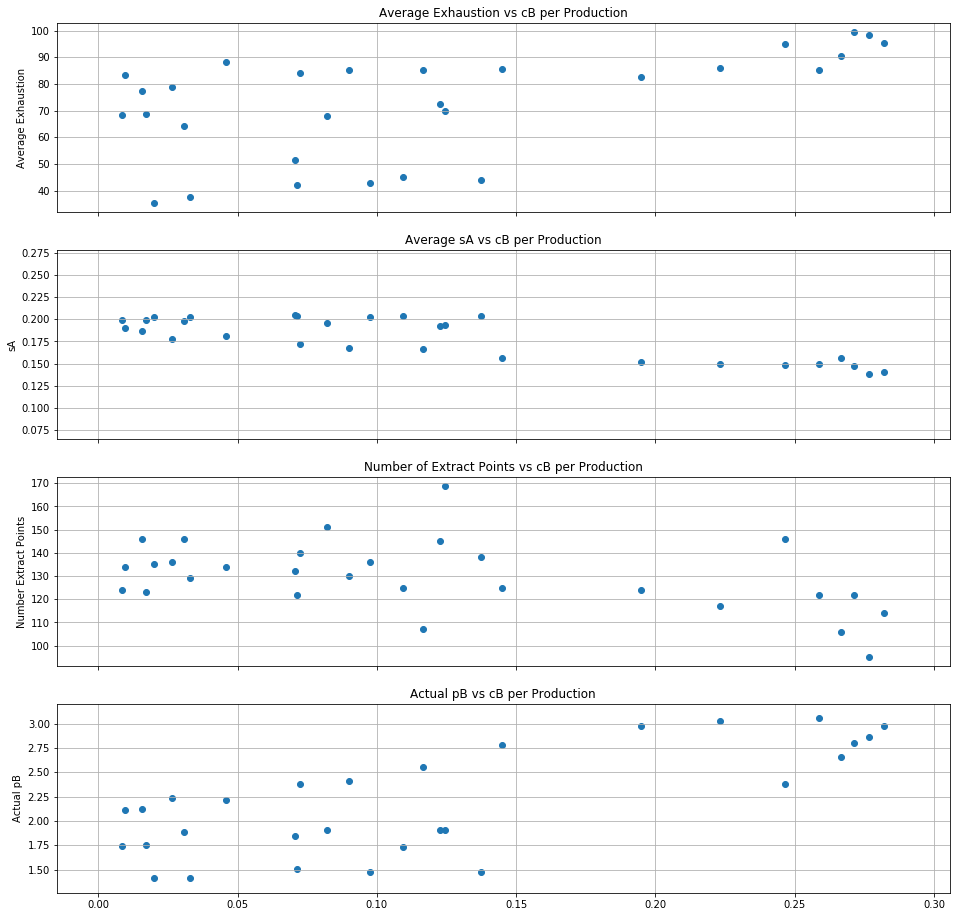

In [16]:
# Scatter plots to visualize possible relationships
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,sharex=True)
ax1.scatter(monthly_pB['cB_per_prod'],monthly_pB['average_exhaustion'])
ax1.set_ylabel('Average Exhaustion')
ax1.grid(True)
ax1.set_title('Average Exhaustion vs cB per Production')
ax2.scatter(monthly_pB['cB_per_prod'],monthly_pB['average_sA'])
ax2.set_ylabel('sA')
ax2.grid(True)
ax2.set_title('Average sA vs cB per Production')
ax3.scatter(monthly_pB['cB_per_prod'],monthly_pB['number_extract_points'])
ax3.set_ylabel('Number Extract Points')
ax3.grid(True)
ax3.set_title('Number of Extract Points vs cB per Production')
ax4.scatter(monthly_pB['cB_per_prod'],monthly_pB['average_pB'])
ax4.set_ylabel('Actual pB')
ax4.grid(True)
ax4.set_title('Actual pB vs cB per Production')

fig.set_size_inches(16,16)
fig.savefig('Images/cB_per_prod_scatters.png',dpi=100)
plt.show()

C:\Users\Adrianna\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


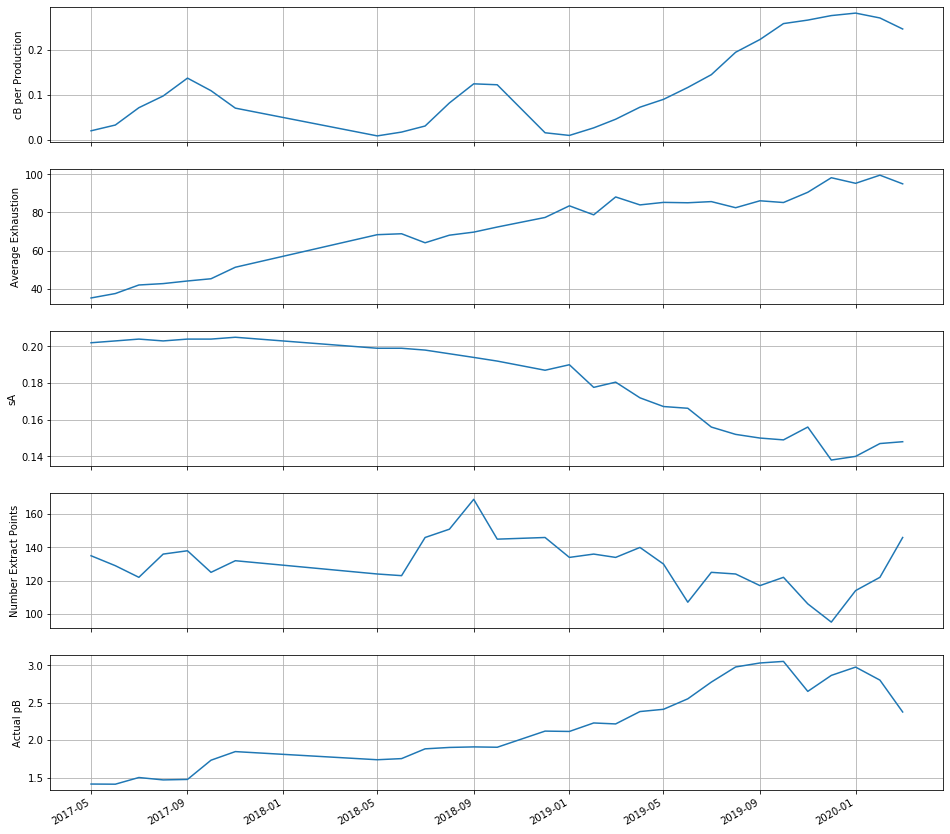

In [17]:
# plotting on time scale to see why there is such variation
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,sharex=True)
ax1.plot(monthly_pB['datetime'],monthly_pB['cB_per_prod'])
ax1.set_ylabel('cB per Production')
ax1.grid(True)
ax2.plot(monthly_pB['datetime'],monthly_pB['average_exhaustion'])
ax2.set_ylabel('Average Exhaustion')
ax2.grid(True)
ax3.plot(monthly_pB['datetime'],monthly_pB['average_sA'])
ax3.set_ylabel('sA')
ax3.grid(True)
ax4.plot(monthly_pB['datetime'],monthly_pB['number_extract_points'])
ax4.set_ylabel('Number Extract Points')
ax4.grid(True)
ax5.plot(monthly_pB['datetime'],monthly_pB['average_pB'])
ax5.set_ylabel('Actual pB')
ax5.grid(True)

fig.autofmt_xdate()
fig.set_size_inches(16,16)
fig.savefig('Images/cB_per_prod_plots.png',dpi=100)
plt.show()

In [18]:
# Perform forward selection on possible features
monthly_sel = monthly_pB[['average_exhaustion','average_sA','number_extract_points','average_pB','cB_per_prod']]
model = forward_selected(monthly_sel,'cB_per_prod')
print(model.model.formula)
print(model.rsquared_adj)

cB_per_prod ~ average_sA + average_exhaustion + 1
0.7161123778338311


In [19]:
# sA and exhaustion are best for cB

In [20]:
##########################
# pD Testing Starts Here #
##########################

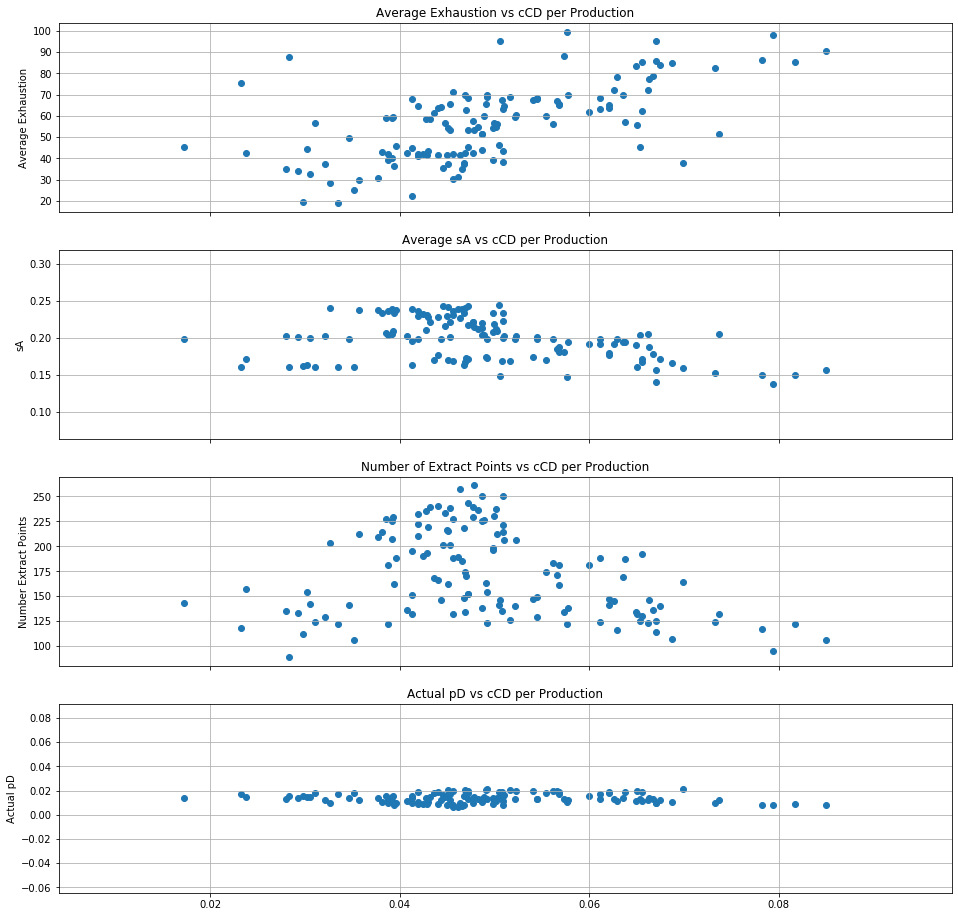

In [21]:
# Scatter plots to visualize possible relationships
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,sharex=True)
ax1.scatter(monthly_pD['cCD_per_prod'],monthly_pD['average_exhaustion'])
ax1.set_ylabel('Average Exhaustion')
ax1.grid(True)
ax1.set_title('Average Exhaustion vs cCD per Production')
ax2.scatter(monthly_pD['cCD_per_prod'],monthly_pD['average_sA'])
ax2.set_ylabel('sA')
ax2.grid(True)
ax2.set_title('Average sA vs cCD per Production')
ax3.scatter(monthly_pD['cCD_per_prod'],monthly_pD['number_extract_points'])
ax3.set_ylabel('Number Extract Points')
ax3.grid(True)
ax3.set_title('Number of Extract Points vs cCD per Production')
ax4.scatter(monthly_pD['cCD_per_prod'],monthly_pD['average_pD'])
ax4.set_ylabel('Actual pD')
ax4.grid(True)
ax4.set_title('Actual pD vs cCD per Production')

fig.set_size_inches(16,16)
fig.savefig('Images/cCD_per_prod_scatters.png',dpi=100)
plt.show()

In [22]:
# Perform forward selection on possible features
monthly_sel = monthly_pD[['average_exhaustion','average_sA','number_extract_points','average_pD','cCD_per_prod']]
model = forward_selected(monthly_sel,'cCD_per_prod')
print(model.model.formula)
print(model.rsquared_adj)

cCD_per_prod ~ average_exhaustion + average_pD + 1
0.3988132221663473


In [23]:
# pD and exhaustion are best for cCD
# Due to the low correlations, SVM will be investigated

In [24]:
##########################
# pA Testing Starts Here #
##########################

In [25]:
from sklearn.svm import SVR
X = monthly_pA[['average_pA', 'average_exhaustion','number_extract_points']]
y = monthly_pA['cA_per_prod'].values.reshape(-1,1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [27]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
# Format y so it is usable
y_ravel = y_train_scaled.ravel()
y_train_array = np.array(y_ravel).astype(float)
y_test_ravel = y_test_scaled.ravel()
y_test_array = np.array(y_test_ravel).astype(float)

In [28]:
# Performing standard OLS regression first, more as a check that the random_state is valid
model = LinearRegression()
model.fit(X_train,y_train)
training_score = model.score(X_train,y_train)
testing_score = model.score(X_test,y_test)
print(f'Training Score: {training_score}')
print(f'Testing Score: {testing_score}')
coeffs = model.coef_.round(4)
intercept = model.intercept_.round(5)
print(f'cA per Production = {coeffs[0][0]}*pA + {intercept[0]}')

Training Score: 0.7744401174178189
Testing Score: 0.6053157819294679
cA per Production = 0.2638*pA + 0.01279


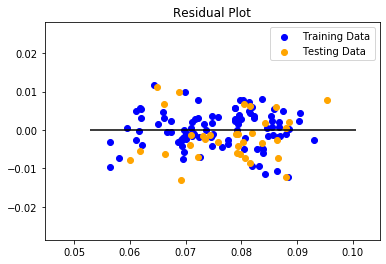

In [29]:
# OLS Residuals
fig, ax = plt.subplots()
ax.scatter(model.predict(X_train),model.predict(X_train) - y_train, c='blue',label='Training Data')
ax.scatter(model.predict(X_test),model.predict(X_test) - y_test, c='orange', label='Testing Data')
plt.legend()
plt.hlines(y=0,xmin=y.min(),xmax=y.max())
plt.title('Residual Plot')
fig.set_size_inches(6, 4)
plt.show()

In [30]:
# Linear SVR kernel
model = SVR(kernel='linear')
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10],
              'gamma': [0.001, 0.01, 0.1]}
grid = GridSearchCV(model, param_grid, verbose=3, cv=5)

In [31]:
grid.fit(X_train_scaled, y_train_array)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.814, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.700, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.714, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.735, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.758, total=   0.0s
[CV] C=1, gamma=0.01 .................................................
[CV] ..................... C=1, gamma=0.01, score=0.814, total=   0.0s
[CV] C=1, gamma=0.01 .................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.0s finished
C:\Users\Adrianna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated',
                           kernel='linear', max_iter=-1, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 5, 10], 'gamma': [0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [32]:
# List the best parameters for this dataset
print(grid.best_params_)
# List the best score
print(grid.best_score_)

{'C': 5, 'gamma': 0.001}
0.7462062436741755


In [33]:
# RBF SVR kernel
model = SVR(kernel='rbf')
param_grid = {'C': [1, 5, 10],
              'gamma': [0.001, 0.01, 0.1],
             'epsilon':[0.001,0.01,0.1]}
grid = GridSearchCV(model, param_grid, verbose=3, cv=5)

In [34]:
grid.fit(X_train_scaled, y_train_array)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] ..... C=1, epsilon=0.001, gamma=0.001, score=0.286, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] ..... C=1, epsilon=0.001, gamma=0.001, score=0.163, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] ..... C=1, epsilon=0.001, gamma=0.001, score=0.195, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] ..... C=1, epsilon=0.001, gamma=0.001, score=0.281, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] ..... C=1, epsilon=0.001, gamma=0.001, score=0.263, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.01 ..................................
[CV] ...... C=1, epsilon=0.001, gamma=0.01, score=0.749, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.01 ..................................
[CV] ...... C=1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] ....... C=1, epsilon=0.1, gamma=0.001, score=0.272, total=   0.0s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] ....... C=1, epsilon=0.1, gamma=0.001, score=0.153, total=   0.0s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] ....... C=1, epsilon=0.1, gamma=0.001, score=0.207, total=   0.0s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] ....... C=1, epsilon=0.1, gamma=0.001, score=0.262, total=   0.0s
[CV] C=1, epsilon=0.1, gamma=0.001 ...................................
[CV] ....... C=1, epsilon=0.1, gamma=0.001, score=0.277, total=   0.0s
[CV] C=1, epsilon=0.1, gamma=0.01 ....................................
[CV] ........ C=1, epsilon=0.1, gamma=0.01, score=0.754, total=   0.0s
[CV] C=1, epsilon=0.1, gamma=0.01 ....................................
[CV] ........ C=1, epsilon=0.1, gamma=0.01, score=0.572, total=   0.0s
[CV] 

[CV] ....... C=10, epsilon=0.1, gamma=0.01, score=0.711, total=   0.0s
[CV] C=10, epsilon=0.1, gamma=0.01 ...................................
[CV] ....... C=10, epsilon=0.1, gamma=0.01, score=0.766, total=   0.0s
[CV] C=10, epsilon=0.1, gamma=0.01 ...................................
[CV] ....... C=10, epsilon=0.1, gamma=0.01, score=0.761, total=   0.0s
[CV] C=10, epsilon=0.1, gamma=0.1 ....................................
[CV] ........ C=10, epsilon=0.1, gamma=0.1, score=0.815, total=   0.0s
[CV] C=10, epsilon=0.1, gamma=0.1 ....................................
[CV] ........ C=10, epsilon=0.1, gamma=0.1, score=0.780, total=   0.0s
[CV] C=10, epsilon=0.1, gamma=0.1 ....................................
[CV] ........ C=10, epsilon=0.1, gamma=0.1, score=0.740, total=   0.0s
[CV] C=10, epsilon=0.1, gamma=0.1 ....................................
[CV] ........ C=10, epsilon=0.1, gamma=0.1, score=0.813, total=   0.0s
[CV] C=10, epsilon=0.1, gamma=0.1 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    0.1s finished
C:\Users\Adrianna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 5, 10], 'epsilon': [0.001, 0.01, 0.1],
                         'gamma': [0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [35]:
# List the best parameters for this dataset
print(grid.best_params_)
# List the best score
print(grid.best_score_)

{'C': 10, 'epsilon': 0.1, 'gamma': 0.1}
0.7671646925480103


In [36]:
# Polynomial SVR kernel
model = SVR(kernel='poly')
param_grid = {'degree':[2,3,4],
              'C': [1, 5, 10],
              'gamma': [0.001, 0.01, 0.1],
             'epsilon':[0.001,0.01,0.1],
             'coef0':[min(1-X_train_scaled.min(),0),max(X_train_scaled.max(),y_train_array.max())]}
grid = GridSearchCV(model, param_grid, verbose=3, cv=5)

In [37]:
grid.fit(X_train_scaled, y_train_array)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.044, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.098, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.037, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.010, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.053, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.01, score=-0.038, total=   0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=1, coef0=0, degree=3, epsilon=0.001, gamma=0.1, score=0.500, total=   0.0s
[CV] C=1, coef0=0, degree=3, epsilon=0.001, gamma=0.1 ................
[CV]  C=1, coef0=0, degree=3, epsilon=0.001, gamma=0.1, score=0.512, total=   0.0s
[CV] C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001 ...............
[CV]  C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001, score=-0.044, total=   0.0s
[CV] C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001 ...............
[CV]  C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001, score=-0.098, total=   0.0s
[CV] C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001 ...............
[CV]  C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001, score=-0.038, total=   0.0s
[CV] C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001 ...............
[CV]  C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001, score=-0.010, total=   0.0s
[CV] C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001 ...............
[CV]  C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001, score=-0.05

[CV] C=1, coef0=0, degree=4, epsilon=0.1, gamma=0.001 ................
[CV]  C=1, coef0=0, degree=4, epsilon=0.1, gamma=0.001, score=-0.076, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.1, gamma=0.001 ................
[CV]  C=1, coef0=0, degree=4, epsilon=0.1, gamma=0.001, score=-0.066, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.1, gamma=0.001 ................
[CV]  C=1, coef0=0, degree=4, epsilon=0.1, gamma=0.001, score=-0.013, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.1, gamma=0.001 ................
[CV]  C=1, coef0=0, degree=4, epsilon=0.1, gamma=0.001, score=-0.035, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.1, gamma=0.01 .................
[CV]  C=1, coef0=0, degree=4, epsilon=0.1, gamma=0.01, score=-0.029, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.1, gamma=0.01 .................
[CV]  C=1, coef0=0, degree=4, epsilon=0.1, gamma=0.01, score=-0.076, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.1, gamma=0.01 .................
[

[CV] C=1, coef0=2.5355581825165086, degree=2, epsilon=0.1, gamma=0.01 
[CV]  C=1, coef0=2.5355581825165086, degree=2, epsilon=0.1, gamma=0.01, score=0.806, total=   0.0s
[CV] C=1, coef0=2.5355581825165086, degree=2, epsilon=0.1, gamma=0.01 
[CV]  C=1, coef0=2.5355581825165086, degree=2, epsilon=0.1, gamma=0.01, score=0.653, total=   0.0s
[CV] C=1, coef0=2.5355581825165086, degree=2, epsilon=0.1, gamma=0.01 
[CV]  C=1, coef0=2.5355581825165086, degree=2, epsilon=0.1, gamma=0.01, score=0.667, total=   0.0s
[CV] C=1, coef0=2.5355581825165086, degree=2, epsilon=0.1, gamma=0.01 
[CV]  C=1, coef0=2.5355581825165086, degree=2, epsilon=0.1, gamma=0.01, score=0.705, total=   0.0s
[CV] C=1, coef0=2.5355581825165086, degree=2, epsilon=0.1, gamma=0.01 
[CV]  C=1, coef0=2.5355581825165086, degree=2, epsilon=0.1, gamma=0.01, score=0.756, total=   0.0s
[CV] C=1, coef0=2.5355581825165086, degree=2, epsilon=0.1, gamma=0.1 .
[CV]  C=1, coef0=2.5355581825165086, degree=2, epsilon=0.1, gamma=0.1, score=0.

[CV]  C=1, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.001, score=0.678, total=   0.0s
[CV] C=1, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.001 
[CV]  C=1, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.001, score=0.720, total=   0.0s
[CV] C=1, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.001 
[CV]  C=1, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.001, score=0.763, total=   0.0s
[CV] C=1, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.01 
[CV]  C=1, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.01, score=0.836, total=   0.0s
[CV] C=1, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.01 
[CV]  C=1, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.01, score=0.734, total=   0.0s
[CV] C=1, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.01 
[CV]  C=1, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.01, score=0.743, total=   0.0s
[CV] C=1, coef0=2.5355581825165086, degree=4, 

[CV]  C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.01, score=-0.033, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1 .................
[CV]  C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1, score=0.472, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1 .................
[CV]  C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1, score=0.518, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1 .................
[CV]  C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1, score=0.268, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1 .................
[CV]  C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1, score=0.512, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1 .................
[CV]  C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1, score=0.607, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.1, gamma=0.001 ................
[CV]  C=5, coef0=0, degree=3, epsilon=0.1, gamma=0.001, score=-0.029, total=   0

[CV]  C=5, coef0=0, degree=4, epsilon=0.1, gamma=0.1, score=0.286, total=   0.0s
[CV] C=5, coef0=0, degree=4, epsilon=0.1, gamma=0.1 ..................
[CV]  C=5, coef0=0, degree=4, epsilon=0.1, gamma=0.1, score=0.189, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.001 
[CV]  C=5, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.001, score=0.770, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.001 
[CV]  C=5, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.001, score=0.603, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.001 
[CV]  C=5, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.001, score=0.651, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.001 
[CV]  C=5, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.001, score=0.632, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=2, epsilon=0.001, ga

[CV]  C=5, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.1, score=0.711, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.1 
[CV]  C=5, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.1, score=0.764, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.1 
[CV]  C=5, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.1, score=0.574, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=3, epsilon=0.1, gamma=0.001 
[CV]  C=5, coef0=2.5355581825165086, degree=3, epsilon=0.1, gamma=0.001, score=0.813, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=3, epsilon=0.1, gamma=0.001 
[CV]  C=5, coef0=2.5355581825165086, degree=3, epsilon=0.1, gamma=0.001, score=0.681, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=3, epsilon=0.1, gamma=0.001 
[CV]  C=5, coef0=2.5355581825165086, degree=3, epsilon=0.1, gamma=0.001, score=0.687, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=3,

[CV]  C=5, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.1, score=0.805, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.1 .
[CV]  C=5, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.1, score=0.779, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.1 .
[CV]  C=5, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.1, score=0.715, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.1 .
[CV]  C=5, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.1, score=0.720, total=   0.0s
[CV] C=5, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.1 .
[CV]  C=5, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.1, score=0.579, total=   0.0s
[CV] C=10, coef0=0, degree=2, epsilon=0.001, gamma=0.001 .............
[CV]  C=10, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.043, total=   0.0s
[CV] C=10, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ...........

[CV]  C=10, coef0=0, degree=3, epsilon=0.01, gamma=0.001, score=-0.010, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.01, gamma=0.001 ..............
[CV]  C=10, coef0=0, degree=3, epsilon=0.01, gamma=0.001, score=-0.052, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.01, gamma=0.01 ...............
[CV]  C=10, coef0=0, degree=3, epsilon=0.01, gamma=0.01, score=-0.016, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.01, gamma=0.01 ...............
[CV]  C=10, coef0=0, degree=3, epsilon=0.01, gamma=0.01, score=-0.074, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.01, gamma=0.01 ...............
[CV]  C=10, coef0=0, degree=3, epsilon=0.01, gamma=0.01, score=-0.001, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.01, gamma=0.01 ...............
[CV]  C=10, coef0=0, degree=3, epsilon=0.01, gamma=0.01, score=0.027, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.01, gamma=0.01 ...............
[CV]  C=10, coef0=0, degree=3, epsilon=0.01, gamma=0.01, score=

[CV]  C=10, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.1, score=0.730, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.1 
[CV]  C=10, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.1, score=0.692, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.1 
[CV]  C=10, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.1, score=0.749, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.1 
[CV]  C=10, coef0=2.5355581825165086, degree=2, epsilon=0.001, gamma=0.1, score=0.612, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=2, epsilon=0.01, gamma=0.001 
[CV]  C=10, coef0=2.5355581825165086, degree=2, epsilon=0.01, gamma=0.001, score=0.807, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=2, epsilon=0.01, gamma=0.001 
[CV]  C=10, coef0=2.5355581825165086, degree=2, epsilon=0.01, gamma=0.001, score=0.669, total=   0.0s
[CV] C=10, coef0=2.535558

[CV]  C=10, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.001, score=0.762, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.01 
[CV]  C=10, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.01, score=0.829, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.01 
[CV]  C=10, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.01, score=0.725, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.01 
[CV]  C=10, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.01, score=0.730, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.01 
[CV]  C=10, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.01, score=0.766, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.01 
[CV]  C=10, coef0=2.5355581825165086, degree=3, epsilon=0.01, gamma=0.01, score=0.749, total=   0.0s
[CV] C=10, coef0=2.535558182

[CV]  C=10, coef0=2.5355581825165086, degree=4, epsilon=0.01, gamma=0.1, score=0.769, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=4, epsilon=0.01, gamma=0.1 
[CV]  C=10, coef0=2.5355581825165086, degree=4, epsilon=0.01, gamma=0.1, score=0.694, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=4, epsilon=0.01, gamma=0.1 
[CV]  C=10, coef0=2.5355581825165086, degree=4, epsilon=0.01, gamma=0.1, score=0.742, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=4, epsilon=0.01, gamma=0.1 
[CV]  C=10, coef0=2.5355581825165086, degree=4, epsilon=0.01, gamma=0.1, score=0.609, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.001 
[CV]  C=10, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.001, score=0.813, total=   0.0s
[CV] C=10, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.001 
[CV]  C=10, coef0=2.5355581825165086, degree=4, epsilon=0.1, gamma=0.001, score=0.704, total=   0.0s
[CV] C=10, coef0=2.5355581825165086,

[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:    1.3s finished
C:\Users\Adrianna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 5, 10], 'coef0': [0, 2.5355581825165086],
                         'degree': [2, 3, 4], 'epsilon': [0.001, 0.01, 0.1],
                         'gamma': [0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [38]:
# List the best parameters for this dataset
print(grid.best_params_)
# List the best score
print(grid.best_score_)

{'C': 10, 'coef0': 2.5355581825165086, 'degree': 3, 'epsilon': 0.1, 'gamma': 0.01}
0.7698868350154465


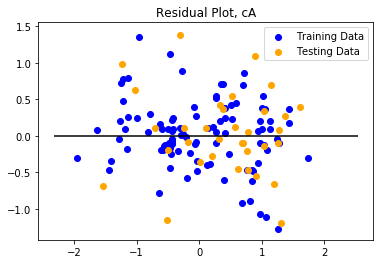

In [39]:
# RBF model is the best for cA regression
# Plot cA residuals based on RBF SVR model
model = SVR(kernel='poly', C=10, gamma=0.01, epsilon=0.1, degree=3, coef0=2.5355581825165086)
X_train_x = model.fit(X_train_scaled,y_train_array).predict(X_train_scaled)
X_test_x = model.fit(X_test_scaled,y_test_array).predict(X_test_scaled)
plt.scatter(X_train_x,X_train_x - y_train_array, c='blue',label='Training Data')
plt.scatter(X_test_x,X_test_x - y_test_array, c='orange', label='Testing Data')
plt.legend()
plt.hlines(y=0,xmin=y_train_array.min(),xmax=y_train_array.max())
plt.title('Residual Plot, cA')
fig.set_size_inches(6, 4)
plt.show()

In [40]:
# Plot actual and predicted values
# Transform full set of data
X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y)
# Change y into terms that the SVR can use
y_ravel = y_scaled.ravel()
y_array = np.array(y_ravel).astype(float)

In [41]:
model = SVR(kernel='poly', C=10, gamma=0.01, epsilon=0.1, degree=3, coef0=2.5355581825165086)
# Inverse the transformation of y
y_predicted = y_scaler.inverse_transform((model.fit(X_scaled,y_array).predict(X_scaler.transform(X))))

In [42]:
monthly_pA['Predicted_cA'] = y_predicted
monthly_pA['cA_Error'] = monthly_pA['Predicted_cA'] - monthly_pA['cA_per_prod']
monthly_pA.tail()

,year_month,average_exhaustion,average_sA,number_extract_points,average_pA,Predicted_pA,Error,datetime,cA,production,cA_per_prod,Predicted_cA,cA_Error
130,201911,90.60,0.156,106.0,0.128,0.154168,0.026168,2019-11-01,16409.0,245938,0.065294,0.061178,-0.004116
131,201912,98.23,0.138,95.0,0.137,0.135136,-0.001864,2019-12-01,11378.0,189351,0.063537,0.062303,-0.001234
132,202001,95.30,0.140,114.0,0.141,0.137821,-0.003179,2020-01-01,20915.0,302346,0.066025,0.063515,-0.002510
133,202002,99.56,0.147,122.0,0.150,0.143243,-0.006757,2020-02-01,16427.0,275361,0.063515,0.064846,0.001330
134,202003,95.02,0.148,146.0,0.129,0.145427,0.016427,2020-03-01,19265.0,381275,0.059028,0.063012,0.003984


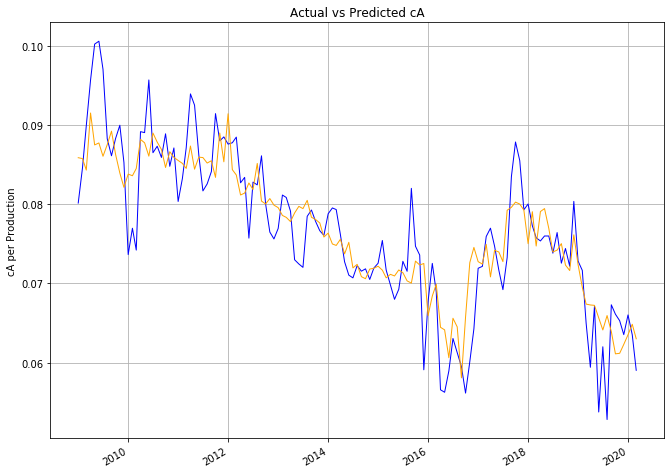

In [43]:
fig, ax1 = plt.subplots()
ax1.plot(monthly_pA['datetime'],monthly_pA['cA_per_prod'],c='blue',linewidth = 1)
ax1.plot(monthly_pA['datetime'],monthly_pA['Predicted_cA'],c='orange',linewidth = 1)
ax1.set_ylabel('cA per Production')

fig.autofmt_xdate()
plt.grid(True)
plt.title('Actual vs Predicted cA')
fig.set_size_inches(11, 8.5)
# fig.savefig('Images/monthly_pA_rbf.png', dpi=100)
plt.show()

In [44]:
print("MSE for the multivariate, RBF regression: "+str(mean_squared_error(monthly_pA['cA_per_prod'],monthly_pA['Predicted_cA'])))
print("the R2 Score for the multivariate, RBF regression: "+str(model.score(X_scaled,y_array)))

MSE for the multivariate, RBF regression: 2.429961164856915e-05
the R2 Score for the multivariate, RBF regression: 0.7547238100706506


In [45]:
monthly_pA.to_csv('Resources/monthly_pA_cA.csv',index=False)

In [46]:
##########################
# pB Testing Starts Here #
##########################

In [47]:
X = monthly_pB[['average_sA','average_exhaustion']]
y = monthly_pB['cB_per_prod'].values.reshape(-1,1)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [49]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
# Format y so it is usable
y_ravel = y_train_scaled.ravel()
y_train_array = np.array(y_ravel).astype(float)
y_test_ravel = y_test_scaled.ravel()
y_test_array = np.array(y_test_ravel).astype(float)

In [50]:
# Performing standard OLS regression first, more as a check that the random_state is valid
model = LinearRegression()
model.fit(X_train,y_train)
training_score = model.score(X_train,y_train)
testing_score = model.score(X_test,y_test)
print(f'Training Score: {training_score}')
print(f'Testing Score: {testing_score}')
coeffs = model.coef_.round(4)
intercept = model.intercept_.round(5)
print(f'cB per Production = {coeffs[0][0]}*pB + {intercept[0]}')

Training Score: 0.7681082064535303
Testing Score: 0.5228812938041789
cB per Production = -5.211*pB + 1.23933


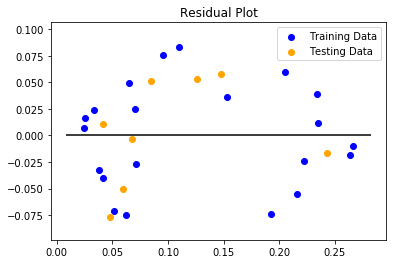

In [51]:
# OLS Residuals
fig, ax = plt.subplots()
ax.scatter(model.predict(X_train),model.predict(X_train) - y_train, c='blue',label='Training Data')
ax.scatter(model.predict(X_test),model.predict(X_test) - y_test, c='orange', label='Testing Data')
plt.legend()
plt.hlines(y=0,xmin=y.min(),xmax=y.max())
plt.title('Residual Plot')
fig.set_size_inches(6, 4)
plt.show()

In [52]:
# Linear SVR kernel
model = SVR(kernel='linear')
param_grid = {'C': [1, 5, 10],
              'gamma': [0.001, 0.01, 0.1]}
grid = GridSearchCV(model, param_grid, verbose=3, cv=5)

In [53]:
grid.fit(X_train_scaled, y_train_array)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.633, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.639, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.490, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] ................... C=1, gamma=0.001, score=-0.952, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.376, total=   0.0s
[CV] C=1, gamma=0.01 .................................................
[CV] ..................... C=1, gamma=0.01, score=0.633, total=   0.0s
[CV] C=1, gamma=0.01 .................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.0s finished
C:\Users\Adrianna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated',
                           kernel='linear', max_iter=-1, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 5, 10], 'gamma': [0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [54]:
# List the best parameters for this dataset
print(grid.best_params_)
# List the best score
print(grid.best_score_)

{'C': 10, 'gamma': 0.001}
0.45407545387644666


In [55]:
# RBF SVR kernel
model = SVR(kernel='rbf')
param_grid = {'C': [1, 5, 10],
              'gamma': [0.001, 0.01, 0.1],
             'epsilon':[0.001,0.01,0.1]}
grid = GridSearchCV(model, param_grid, verbose=3, cv=5)

In [56]:
grid.fit(X_train_scaled, y_train_array)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] .... C=1, epsilon=0.001, gamma=0.001, score=-0.038, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] .... C=1, epsilon=0.001, gamma=0.001, score=-0.090, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] ..... C=1, epsilon=0.001, gamma=0.001, score=0.068, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] .... C=1, epsilon=0.001, gamma=0.001, score=-2.736, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] .... C=1, epsilon=0.001, gamma=0.001, score=-0.364, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.01 ..................................
[CV] ...... C=1, epsilon=0.001, gamma=0.01, score=0.238, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.01 ..................................
[CV] ...... C=1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .... C=10, epsilon=0.001, gamma=0.001, score=0.318, total=   0.0s
[CV] C=10, epsilon=0.001, gamma=0.001 ................................
[CV] ... C=10, epsilon=0.001, gamma=0.001, score=-1.850, total=   0.0s
[CV] C=10, epsilon=0.001, gamma=0.001 ................................
[CV] ... C=10, epsilon=0.001, gamma=0.001, score=-0.008, total=   0.0s
[CV] C=10, epsilon=0.001, gamma=0.01 .................................
[CV] ..... C=10, epsilon=0.001, gamma=0.01, score=0.584, total=   0.0s
[CV] C=10, epsilon=0.001, gamma=0.01 .................................
[CV] ..... C=10, epsilon=0.001, gamma=0.01, score=0.676, total=   0.0s
[CV] C=10, epsilon=0.001, gamma=0.01 .................................
[CV] ..... C=10, epsilon=0.001, gamma=0.01, score=0.461, total=   0.0s
[CV] C=10, epsilon=0.001, gamma=0.01 .................................
[CV] .... C=10, epsilon=0.001, gamma=0.01, score=-1.628, total=   0.0s
[CV] C=10, epsilon=0.001, gamma=0.01 .................................
[CV] .

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    0.1s finished
C:\Users\Adrianna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 5, 10], 'epsilon': [0.001, 0.01, 0.1],
                         'gamma': [0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [57]:
# List the best parameters for this dataset
print(grid.best_params_)
# List the best score
print(grid.best_score_)

{'C': 5, 'epsilon': 0.01, 'gamma': 0.1}
0.7889082788766987


In [58]:
# Polynomial SVR kernel
model = SVR(kernel='poly')
param_grid = {'degree':[2,3,4],
              'C': [1, 5, 10],
              'gamma': [0.001, 0.01, 0.1],
             'epsilon':[0.001,0.01,0.1],
             'coef0':[min(1-X_train_scaled.min(),0),max(X_train_scaled.max(),y_train_array.max())]}
grid = GridSearchCV(model, param_grid, verbose=3, cv=5)

In [59]:
grid.fit(X_train_scaled, y_train_array)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.101, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.144, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.010, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-2.572, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.523, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.01, score=-0.100, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.01, score=-0.143, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.01, score=-0.010, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.01, sco

[CV]  C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01, score=-0.144, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01, score=-0.010, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01, score=-2.573, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01, score=-0.523, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.1 ................
[CV]  C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.1, score=-0.090, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.1 ................
[CV]  C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.1, score=-0.140, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.1 ................
[CV]  C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.1, score=-0.0

[CV]  C=1, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.001, score=-0.059, total=   0.0s
[CV] C=1, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.001 
[CV]  C=1, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.001, score=0.112, total=   0.0s
[CV] C=1, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.001 
[CV]  C=1, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.001, score=-2.540, total=   0.0s
[CV] C=1, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.001 
[CV]  C=1, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.001, score=-0.279, total=   0.0s
[CV] C=1, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.01 
[CV]  C=1, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.01, score=0.306, total=   0.0s
[CV] C=1, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.01 
[CV]  C=1, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.01, score=0.359, total=   0.0s
[CV] C=1, coef0=1.577125672183322, degree

[CV] C=1, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.001 
[CV]  C=1, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.001, score=0.060, total=   0.0s
[CV] C=1, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.01 .
[CV]  C=1, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.01, score=0.615, total=   0.0s
[CV] C=1, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.01 .
[CV]  C=1, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.01, score=0.655, total=   0.0s
[CV] C=1, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.01 .
[CV]  C=1, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.01, score=0.515, total=   0.0s
[CV] C=1, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.01 .
[CV]  C=1, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.01, score=-1.778, total=   0.0s
[CV] C=1, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.01 .
[CV]  C=1, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.01, score=0.382

[CV] C=5, coef0=0, degree=2, epsilon=0.1, gamma=0.1 ..................
[CV]  C=5, coef0=0, degree=2, epsilon=0.1, gamma=0.1, score=-0.132, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.001, gamma=0.001 ..............
[CV]  C=5, coef0=0, degree=3, epsilon=0.001, gamma=0.001, score=-0.101, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.001, gamma=0.001 ..............
[CV]  C=5, coef0=0, degree=3, epsilon=0.001, gamma=0.001, score=-0.144, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.001, gamma=0.001 ..............
[CV]  C=5, coef0=0, degree=3, epsilon=0.001, gamma=0.001, score=-0.010, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.001, gamma=0.001 ..............
[CV]  C=5, coef0=0, degree=3, epsilon=0.001, gamma=0.001, score=-2.573, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.001, gamma=0.001 ..............
[CV]  C=5, coef0=0, degree=3, epsilon=0.001, gamma=0.001, score=-0.523, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.001, gamma=0.01 .......

[CV]  C=5, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.001, score=-1.776, total=   0.0s
[CV] C=5, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.001 
[CV]  C=5, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.001, score=-0.037, total=   0.0s
[CV] C=5, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.01 
[CV]  C=5, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.01, score=0.562, total=   0.0s
[CV] C=5, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.01 
[CV]  C=5, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.01, score=0.662, total=   0.0s
[CV] C=5, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.01 
[CV]  C=5, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.01, score=0.294, total=   0.0s
[CV] C=5, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.01 
[CV]  C=5, coef0=1.577125672183322, degree=2, epsilon=0.01, gamma=0.01, score=-1.648, total=   0.0s
[CV] C=5, coef0=1.577125672183322, degree=2, 

[CV] C=5, coef0=1.577125672183322, degree=3, epsilon=0.01, gamma=0.1 .
[CV]  C=5, coef0=1.577125672183322, degree=3, epsilon=0.01, gamma=0.1, score=0.874, total=   0.0s
[CV] C=5, coef0=1.577125672183322, degree=3, epsilon=0.01, gamma=0.1 .
[CV]  C=5, coef0=1.577125672183322, degree=3, epsilon=0.01, gamma=0.1, score=0.819, total=   0.0s
[CV] C=5, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.001 
[CV]  C=5, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.001, score=0.365, total=   0.0s
[CV] C=5, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.001 
[CV]  C=5, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.001, score=0.328, total=   0.0s
[CV] C=5, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.001 
[CV]  C=5, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.001, score=0.334, total=   0.0s
[CV] C=5, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.001 
[CV]  C=5, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.001, score=-1.

[CV] C=10, coef0=0, degree=3, epsilon=0.001, gamma=0.001 .............
[CV]  C=10, coef0=0, degree=3, epsilon=0.001, gamma=0.001, score=-2.573, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.001, gamma=0.001 .............
[CV]  C=10, coef0=0, degree=3, epsilon=0.001, gamma=0.001, score=-0.523, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.001, gamma=0.01 ..............
[CV]  C=10, coef0=0, degree=3, epsilon=0.001, gamma=0.01, score=-0.098, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.001, gamma=0.01 ..............
[CV]  C=10, coef0=0, degree=3, epsilon=0.001, gamma=0.01, score=-0.142, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.001, gamma=0.01 ..............
[CV]  C=10, coef0=0, degree=3, epsilon=0.001, gamma=0.01, score=-0.009, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.001, gamma=0.01 ..............
[CV]  C=10, coef0=0, degree=3, epsilon=0.001, gamma=0.01, score=-2.596, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.001, gamma=0.01 

[CV] C=10, coef0=0, degree=4, epsilon=0.001, gamma=0.1 ...............
[CV]  C=10, coef0=0, degree=4, epsilon=0.001, gamma=0.1, score=-2.957, total=   0.0s
[CV] C=10, coef0=0, degree=4, epsilon=0.001, gamma=0.1 ...............
[CV]  C=10, coef0=0, degree=4, epsilon=0.001, gamma=0.1, score=-0.232, total=   0.0s
[CV] C=10, coef0=0, degree=4, epsilon=0.01, gamma=0.001 ..............
[CV]  C=10, coef0=0, degree=4, epsilon=0.01, gamma=0.001, score=-0.101, total=   0.0s
[CV] C=10, coef0=0, degree=4, epsilon=0.01, gamma=0.001 ..............
[CV]  C=10, coef0=0, degree=4, epsilon=0.01, gamma=0.001, score=-0.144, total=   0.0s
[CV] C=10, coef0=0, degree=4, epsilon=0.01, gamma=0.001 ..............
[CV]  C=10, coef0=0, degree=4, epsilon=0.01, gamma=0.001, score=-0.010, total=   0.0s
[CV] C=10, coef0=0, degree=4, epsilon=0.01, gamma=0.001 ..............
[CV]  C=10, coef0=0, degree=4, epsilon=0.01, gamma=0.001, score=-2.573, total=   0.0s
[CV] C=10, coef0=0, degree=4, epsilon=0.01, gamma=0.001 ....

[CV]  C=10, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.001, score=0.400, total=   0.0s
[CV] C=10, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.001 
[CV]  C=10, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.001, score=-1.968, total=   0.0s
[CV] C=10, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.001 
[CV]  C=10, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.001, score=0.339, total=   0.0s
[CV] C=10, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.01 
[CV]  C=10, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.01, score=0.673, total=   0.0s
[CV] C=10, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.01 
[CV]  C=10, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.01, score=0.707, total=   0.0s
[CV] C=10, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.01 
[CV]  C=10, coef0=1.577125672183322, degree=3, epsilon=0.1, gamma=0.01, score=0.636, total=   0.0s
[CV] C=10, coef0=1.577125672183322, degree=3,

[CV]  C=10, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.01, score=-0.019, total=   0.0s
[CV] C=10, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.01 
[CV]  C=10, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.01, score=0.802, total=   0.0s
[CV] C=10, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.1 .
[CV]  C=10, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.1, score=0.640, total=   0.0s
[CV] C=10, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.1 .
[CV]  C=10, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.1, score=0.812, total=   0.0s
[CV] C=10, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.1 .
[CV]  C=10, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.1, score=0.717, total=   0.0s
[CV] C=10, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.1 .
[CV]  C=10, coef0=1.577125672183322, degree=4, epsilon=0.1, gamma=0.1, score=0.839, total=   0.0s
[CV] C=10, coef0=1.577125672183322, degree=4, epsilon=

[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:    0.8s finished
C:\Users\Adrianna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 5, 10], 'coef0': [0, 1.577125672183322],
                         'degree': [2, 3, 4], 'epsilon': [0.001, 0.01, 0.1],
                         'gamma': [0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [60]:
# List the best parameters for this dataset
print(grid.best_params_)
# List the best score
print(grid.best_score_)

{'C': 10, 'coef0': 1.577125672183322, 'degree': 2, 'epsilon': 0.001, 'gamma': 0.1}
0.7760462823100389


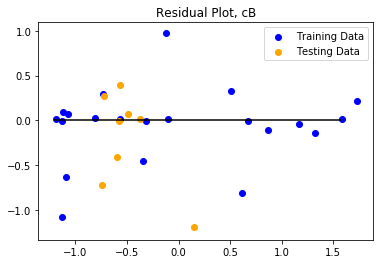

In [61]:
# Poly model is the best for cB regression
# Plot cB residuals based on RBF SVR model
model = SVR(kernel='rbf', C=5, gamma=0.1, epsilon=0.01)
X_train_x = model.fit(X_train_scaled,y_train_array).predict(X_train_scaled)
X_test_x = model.fit(X_test_scaled,y_test_array).predict(X_test_scaled)
plt.scatter(X_train_x,X_train_x - y_train_array, c='blue',label='Training Data')
plt.scatter(X_test_x,X_test_x - y_test_array, c='orange', label='Testing Data')
plt.legend()
plt.hlines(y=0,xmin=y_train_array.min(),xmax=y_train_array.max())
plt.title('Residual Plot, cB')
fig.set_size_inches(6, 4)
plt.show()

In [62]:
# Plot actual and predicted values
X = monthly_pB_full[['average_sA','average_exhaustion']]
y = monthly_pB_full['cB_per_prod'].values.reshape(-1,1)
# Transform full set of data
X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y)
# Change y into terms that the SVR cBn use
y_ravel = y_scaled.ravel()
y_array = np.array(y_ravel).astype(float)

In [63]:
model = SVR(kernel='rbf', C=5, gamma=0.1, epsilon=0.01)
# Inverse the transformation of y
y_predicted = y_scaler.inverse_transform((model.fit(X_scaled,y_array).predict(X_scaler.transform(X))))

In [64]:
monthly_pB_full['Predicted_cB'] = y_predicted
monthly_pB_full['cB_Error'] = monthly_pB_full['Predicted_cB'] - monthly_pB_full['cB_per_prod']
monthly_pB_full.tail(10)

,year_month,average_exhaustion,average_sA,number_extract_points,average_pB,Predicted_pB,Error,datetime,cB,production,cB_per_prod,Predicted_cB,cB_Error
103,201906,85.10,0.16625,107.0,2.552356,2.264162,-0.288194,2019-06-01,62700,407105,0.116530,0.104180,-0.012350
104,201907,85.71,0.15600,125.0,2.775549,2.478843,-0.296706,2019-07-01,91200,506351,0.144965,0.148762,0.003797
105,201908,82.51,0.15200,124.0,2.977560,2.410580,-0.566979,2019-08-01,91200,344203,0.194886,0.147937,-0.046949
106,201909,86.14,0.15000,117.0,3.030762,2.529949,-0.500813,2019-09-01,88350,362179,0.223256,0.177144,-0.046112
107,201910,85.23,0.14900,122.0,3.051775,2.521999,-0.529775,2019-10-01,122550,461360,0.258704,0.176002,-0.082702
108,201911,90.60,0.15600,106.0,2.651545,2.551759,-0.099787,2019-11-01,74100,245938,0.266485,0.174171,-0.092315
109,201912,98.23,0.13800,95.0,2.864889,2.916181,0.051292,2019-12-01,51300,189351,0.276530,0.308144,0.031614
110,202001,95.30,0.14000,114.0,2.975722,2.871313,-0.104409,2020-01-01,82650,302346,0.282050,0.281021,-0.001029
111,202002,99.56,0.14700,122.0,2.801782,2.882224,0.080442,2020-02-01,74100,275361,0.271231,0.270217,-0.001015
112,202003,95.02,0.14800,146.0,2.376562,2.788623,0.412060,2020-03-01,79800,381275,0.246668,0.239535,-0.007133


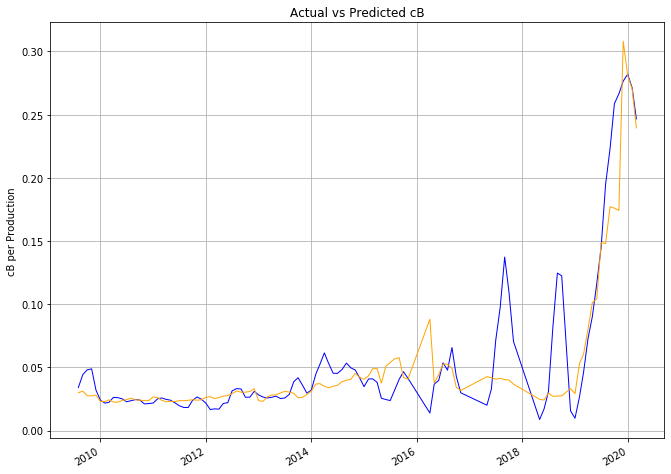

In [65]:
fig, ax1 = plt.subplots()
ax1.plot(monthly_pB_full['datetime'],monthly_pB_full['cB_per_prod'],c='blue',linewidth = 1)
ax1.plot(monthly_pB_full['datetime'],monthly_pB_full['Predicted_cB'],c='orange',linewidth = 1)
ax1.set_ylabel('cB per Production')

fig.autofmt_xdate()
plt.grid(True)
plt.title('Actual vs Predicted cB')
fig.set_size_inches(11, 8.5)
# fig.savefig('Images/monthly_pB_full_rbf.png', dpi=100)
plt.show()

In [66]:
print("MSE for the multivariate, RBF regression: "+str(mean_squared_error(monthly_pB_full['cB_per_prod'],monthly_pB_full['Predicted_cB'])))
print("the R2 Score for the multivariate, RBF regression: "+str(model.score(X_scaled,y_array)))

MSE for the multivariate, RBF regression: 0.0006859209046960163
the R2 Score for the multivariate, RBF regression: 0.8147131520625938


In [67]:
monthly_pB_full.to_csv('Resources/monthly_pB_cB.csv',index=False)

In [68]:
##########################
# pD Testing Starts Here #
##########################

In [69]:
from sklearn.svm import SVR
X = monthly_pD[['average_pD','average_exhaustion']]
y = monthly_pD['cCD_per_prod'].values.reshape(-1,1)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [71]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
# Format y so it is usable
y_ravel = y_train_scaled.ravel()
y_train_array = np.array(y_ravel).astype(float)
y_test_ravel = y_test_scaled.ravel()
y_test_array = np.array(y_test_ravel).astype(float)

In [72]:
# Performing standard OLS regression first, more as a check that the random_state is valid
model = LinearRegression()
model.fit(X_train,y_train)
training_score = model.score(X_train,y_train)
testing_score = model.score(X_test,y_test)
print(f'Training Score: {training_score}')
print(f'Testing Score: {testing_score}')
coeffs = model.coef_.round(4)
intercept = model.intercept_.round(5)
print(f'cCD per Production = {coeffs[0][0]}*pD + {intercept[0]}')

Training Score: 0.44150615792047987
Testing Score: 0.2716260740957215
cCD per Production = -0.4924*pD + 0.03024


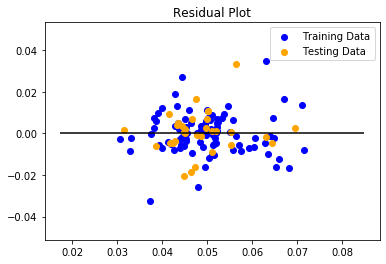

In [73]:
# OLS Residuals
fig, ax = plt.subplots()
ax.scatter(model.predict(X_train),model.predict(X_train) - y_train, c='blue',label='Training Data')
ax.scatter(model.predict(X_test),model.predict(X_test) - y_test, c='orange', label='Testing Data')
plt.legend()
plt.hlines(y=0,xmin=y.min(),xmax=y.max())
plt.title('Residual Plot')
fig.set_size_inches(6, 4)
plt.show()

In [74]:
# Linear SVR kernel
model = SVR(kernel='linear')
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10],
              'gamma': [0.001, 0.01, 0.1]}
grid = GridSearchCV(model, param_grid, verbose=3, cv=5)

In [75]:
grid.fit(X_train_scaled, y_train_array)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.071, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.610, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.532, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.504, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] .................... C=1, gamma=0.001, score=0.201, total=   0.0s
[CV] C=1, gamma=0.01 .................................................
[CV] ..................... C=1, gamma=0.01, score=0.071, total=   0.0s
[CV] C=1, gamma=0.01 .................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.0s finished
C:\Users\Adrianna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated',
                           kernel='linear', max_iter=-1, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 5, 10], 'gamma': [0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [76]:
# List the best parameters for this dataset
print(grid.best_params_)
# List the best score
print(grid.best_score_)

{'C': 10, 'gamma': 0.001}
0.38141562868132545


In [77]:
# RBF SVR kernel
model = SVR(kernel='rbf')
param_grid = {'C': [1, 5, 10],
              'gamma': [0.001, 0.01, 0.1],
             'epsilon':[0.001,0.01,0.1]}
grid = GridSearchCV(model, param_grid, verbose=3, cv=5)

In [78]:
grid.fit(X_train_scaled, y_train_array)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] ..... C=1, epsilon=0.001, gamma=0.001, score=0.065, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] ..... C=1, epsilon=0.001, gamma=0.001, score=0.114, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] ..... C=1, epsilon=0.001, gamma=0.001, score=0.049, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] .... C=1, epsilon=0.001, gamma=0.001, score=-0.012, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.001 .................................
[CV] ..... C=1, epsilon=0.001, gamma=0.001, score=0.086, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.01 ..................................
[CV] ...... C=1, epsilon=0.001, gamma=0.01, score=0.227, total=   0.0s
[CV] C=1, epsilon=0.001, gamma=0.01 ..................................
[CV] ...... C=1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....... C=5, epsilon=0.001, gamma=0.1, score=0.523, total=   0.0s
[CV] C=5, epsilon=0.001, gamma=0.1 ...................................
[CV] ....... C=5, epsilon=0.001, gamma=0.1, score=0.323, total=   0.0s
[CV] C=5, epsilon=0.01, gamma=0.001 ..................................
[CV] ...... C=5, epsilon=0.01, gamma=0.001, score=0.194, total=   0.0s
[CV] C=5, epsilon=0.01, gamma=0.001 ..................................
[CV] ...... C=5, epsilon=0.01, gamma=0.001, score=0.338, total=   0.0s
[CV] C=5, epsilon=0.01, gamma=0.001 ..................................
[CV] ...... C=5, epsilon=0.01, gamma=0.001, score=0.234, total=   0.0s
[CV] C=5, epsilon=0.01, gamma=0.001 ..................................
[CV] ...... C=5, epsilon=0.01, gamma=0.001, score=0.221, total=   0.0s
[CV] C=5, epsilon=0.01, gamma=0.001 ..................................
[CV] ...... C=5, epsilon=0.01, gamma=0.001, score=0.250, total=   0.0s
[CV] C=5, epsilon=0.01, gamma=0.01 ...................................
[CV] .

[CV] ....... C=10, epsilon=0.01, gamma=0.1, score=0.736, total=   0.0s
[CV] C=10, epsilon=0.01, gamma=0.1 ...................................
[CV] ....... C=10, epsilon=0.01, gamma=0.1, score=0.785, total=   0.0s
[CV] C=10, epsilon=0.01, gamma=0.1 ...................................
[CV] ....... C=10, epsilon=0.01, gamma=0.1, score=0.534, total=   0.0s
[CV] C=10, epsilon=0.01, gamma=0.1 ...................................
[CV] ....... C=10, epsilon=0.01, gamma=0.1, score=0.328, total=   0.0s
[CV] C=10, epsilon=0.1, gamma=0.001 ..................................
[CV] ...... C=10, epsilon=0.1, gamma=0.001, score=0.218, total=   0.0s
[CV] C=10, epsilon=0.1, gamma=0.001 ..................................
[CV] ...... C=10, epsilon=0.1, gamma=0.001, score=0.448, total=   0.0s
[CV] C=10, epsilon=0.1, gamma=0.001 ..................................
[CV] ...... C=10, epsilon=0.1, gamma=0.001, score=0.344, total=   0.0s
[CV] C=10, epsilon=0.1, gamma=0.001 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    0.1s finished
C:\Users\Adrianna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 5, 10], 'epsilon': [0.001, 0.01, 0.1],
                         'gamma': [0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [79]:
# List the best parameters for this dataset
print(grid.best_params_)
# List the best score
print(grid.best_score_)

{'C': 10, 'epsilon': 0.1, 'gamma': 0.1}
0.5870808956049332


In [80]:
# Polynomial SVR kernel
model = SVR(kernel='poly')
param_grid = {'degree':[2,3,4],
              'C': [1, 5, 10],
              'gamma': [0.001, 0.01, 0.1],
             'epsilon':[0.001,0.01,0.1],
             'coef0':[min(1-X_train_scaled.min(),0),max(X_train_scaled.max(),y_train_array.max())]}
grid = GridSearchCV(model, param_grid, verbose=3, cv=5)

In [81]:
grid.fit(X_train_scaled, y_train_array)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.009, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.006, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.047, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.175, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001 ..............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.001, score=-0.003, total=   0.0s
[CV] C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=2, epsilon=0.001, gamma=0.01, score=-0.004, total=   0

[CV] C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001 ...............
[CV]  C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001, score=-0.047, total=   0.0s
[CV] C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001 ...............
[CV]  C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001, score=-0.166, total=   0.0s
[CV] C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001 ...............
[CV]  C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.001, score=-0.002, total=   0.0s
[CV] C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.01 ................
[CV]  C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.01, score=-0.009, total=   0.0s
[CV] C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.01 ................
[CV]  C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.01, score=-0.005, total=   0.0s
[CV] C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.01 ................
[CV]  C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.01, score=-0.047, total=   0.0s
[CV] C=1, coef0=0, degree=3, epsilon=0.01, gamma=0.01 .............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01, score=-0.009, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01, score=-0.006, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01, score=-0.047, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01, score=-0.175, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01 ...............
[CV]  C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.01, score=-0.003, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.1 ................
[CV]  C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.1, score=0.091, total=   0.0s
[CV] C=1, coef0=0, degree=4, epsilon=0.001, gamma=0.1 ...........

[CV] C=1, coef0=2.768689473704079, degree=2, epsilon=0.1, gamma=0.01 .
[CV]  C=1, coef0=2.768689473704079, degree=2, epsilon=0.1, gamma=0.01, score=0.431, total=   0.0s
[CV] C=1, coef0=2.768689473704079, degree=2, epsilon=0.1, gamma=0.01 .
[CV]  C=1, coef0=2.768689473704079, degree=2, epsilon=0.1, gamma=0.01, score=0.428, total=   0.0s
[CV] C=1, coef0=2.768689473704079, degree=2, epsilon=0.1, gamma=0.01 .
[CV]  C=1, coef0=2.768689473704079, degree=2, epsilon=0.1, gamma=0.01, score=0.283, total=   0.0s
[CV] C=1, coef0=2.768689473704079, degree=2, epsilon=0.1, gamma=0.1 ..
[CV]  C=1, coef0=2.768689473704079, degree=2, epsilon=0.1, gamma=0.1, score=0.237, total=   0.0s
[CV] C=1, coef0=2.768689473704079, degree=2, epsilon=0.1, gamma=0.1 ..
[CV]  C=1, coef0=2.768689473704079, degree=2, epsilon=0.1, gamma=0.1, score=0.695, total=   0.0s
[CV] C=1, coef0=2.768689473704079, degree=2, epsilon=0.1, gamma=0.1 ..
[CV]  C=1, coef0=2.768689473704079, degree=2, epsilon=0.1, gamma=0.1, score=0.650, tot

[CV] C=1, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.1 ..
[CV]  C=1, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.1, score=0.493, total=   0.0s
[CV] C=1, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.1 ..
[CV]  C=1, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.1, score=0.391, total=   0.0s
[CV] C=1, coef0=2.768689473704079, degree=4, epsilon=0.001, gamma=0.001 
[CV]  C=1, coef0=2.768689473704079, degree=4, epsilon=0.001, gamma=0.001, score=0.129, total=   0.0s
[CV] C=1, coef0=2.768689473704079, degree=4, epsilon=0.001, gamma=0.001 
[CV]  C=1, coef0=2.768689473704079, degree=4, epsilon=0.001, gamma=0.001, score=0.581, total=   0.0s
[CV] C=1, coef0=2.768689473704079, degree=4, epsilon=0.001, gamma=0.001 
[CV]  C=1, coef0=2.768689473704079, degree=4, epsilon=0.001, gamma=0.001, score=0.505, total=   0.0s
[CV] C=1, coef0=2.768689473704079, degree=4, epsilon=0.001, gamma=0.001 
[CV]  C=1, coef0=2.768689473704079, degree=4, epsilon=0.001, gamma=0.

[CV]  C=5, coef0=0, degree=2, epsilon=0.01, gamma=0.001, score=-0.166, total=   0.0s
[CV] C=5, coef0=0, degree=2, epsilon=0.01, gamma=0.001 ...............
[CV]  C=5, coef0=0, degree=2, epsilon=0.01, gamma=0.001, score=-0.002, total=   0.0s
[CV] C=5, coef0=0, degree=2, epsilon=0.01, gamma=0.01 ................
[CV]  C=5, coef0=0, degree=2, epsilon=0.01, gamma=0.01, score=0.015, total=   0.0s
[CV] C=5, coef0=0, degree=2, epsilon=0.01, gamma=0.01 ................
[CV]  C=5, coef0=0, degree=2, epsilon=0.01, gamma=0.01, score=0.017, total=   0.0s
[CV] C=5, coef0=0, degree=2, epsilon=0.01, gamma=0.01 ................
[CV]  C=5, coef0=0, degree=2, epsilon=0.01, gamma=0.01, score=-0.018, total=   0.0s
[CV] C=5, coef0=0, degree=2, epsilon=0.01, gamma=0.01 ................
[CV]  C=5, coef0=0, degree=2, epsilon=0.01, gamma=0.01, score=-0.147, total=   0.0s
[CV] C=5, coef0=0, degree=2, epsilon=0.01, gamma=0.01 ................
[CV]  C=5, coef0=0, degree=2, epsilon=0.01, gamma=0.01, score=-0.012, 

[CV] C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1 .................
[CV]  C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1, score=0.397, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1 .................
[CV]  C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1, score=0.138, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1 .................
[CV]  C=5, coef0=0, degree=3, epsilon=0.01, gamma=0.1, score=0.199, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.1, gamma=0.001 ................
[CV]  C=5, coef0=0, degree=3, epsilon=0.1, gamma=0.001, score=-0.008, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.1, gamma=0.001 ................
[CV]  C=5, coef0=0, degree=3, epsilon=0.1, gamma=0.001, score=-0.005, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.1, gamma=0.001 ................
[CV]  C=5, coef0=0, degree=3, epsilon=0.1, gamma=0.001, score=-0.050, total=   0.0s
[CV] C=5, coef0=0, degree=3, epsilon=0.1, gamma=0.001 ................
[CV] 

[CV]  C=5, coef0=0, degree=4, epsilon=0.1, gamma=0.1, score=-0.036, total=   0.0s
[CV] C=5, coef0=0, degree=4, epsilon=0.1, gamma=0.1 ..................
[CV]  C=5, coef0=0, degree=4, epsilon=0.1, gamma=0.1, score=-0.162, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=2, epsilon=0.001, gamma=0.001 
[CV]  C=5, coef0=2.768689473704079, degree=2, epsilon=0.001, gamma=0.001, score=0.190, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=2, epsilon=0.001, gamma=0.001 
[CV]  C=5, coef0=2.768689473704079, degree=2, epsilon=0.001, gamma=0.001, score=0.483, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=2, epsilon=0.001, gamma=0.001 
[CV]  C=5, coef0=2.768689473704079, degree=2, epsilon=0.001, gamma=0.001, score=0.361, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=2, epsilon=0.001, gamma=0.001 
[CV]  C=5, coef0=2.768689473704079, degree=2, epsilon=0.001, gamma=0.001, score=0.355, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=2, epsilon=0.001, gamma=0.0

[CV]  C=5, coef0=2.768689473704079, degree=3, epsilon=0.001, gamma=0.001, score=0.249, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=3, epsilon=0.001, gamma=0.01 
[CV]  C=5, coef0=2.768689473704079, degree=3, epsilon=0.001, gamma=0.01, score=0.153, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=3, epsilon=0.001, gamma=0.01 
[CV]  C=5, coef0=2.768689473704079, degree=3, epsilon=0.001, gamma=0.01, score=0.675, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=3, epsilon=0.001, gamma=0.01 
[CV]  C=5, coef0=2.768689473704079, degree=3, epsilon=0.001, gamma=0.01, score=0.598, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=3, epsilon=0.001, gamma=0.01 
[CV]  C=5, coef0=2.768689473704079, degree=3, epsilon=0.001, gamma=0.01, score=0.517, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=3, epsilon=0.001, gamma=0.01 
[CV]  C=5, coef0=2.768689473704079, degree=3, epsilon=0.001, gamma=0.01, score=0.290, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degr

[CV]  C=5, coef0=2.768689473704079, degree=4, epsilon=0.01, gamma=0.001, score=0.092, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=4, epsilon=0.01, gamma=0.001 
[CV]  C=5, coef0=2.768689473704079, degree=4, epsilon=0.01, gamma=0.001, score=0.626, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=4, epsilon=0.01, gamma=0.001 
[CV]  C=5, coef0=2.768689473704079, degree=4, epsilon=0.01, gamma=0.001, score=0.536, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=4, epsilon=0.01, gamma=0.001 
[CV]  C=5, coef0=2.768689473704079, degree=4, epsilon=0.01, gamma=0.001, score=0.516, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=4, epsilon=0.01, gamma=0.001 
[CV]  C=5, coef0=2.768689473704079, degree=4, epsilon=0.01, gamma=0.001, score=0.234, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=4, epsilon=0.01, gamma=0.01 
[CV]  C=5, coef0=2.768689473704079, degree=4, epsilon=0.01, gamma=0.01, score=0.363, total=   0.0s
[CV] C=5, coef0=2.768689473704079, degree=

[CV]  C=10, coef0=0, degree=2, epsilon=0.01, gamma=0.1, score=0.490, total=   0.0s
[CV] C=10, coef0=0, degree=2, epsilon=0.01, gamma=0.1 ................
[CV]  C=10, coef0=0, degree=2, epsilon=0.01, gamma=0.1, score=0.078, total=   0.0s
[CV] C=10, coef0=0, degree=2, epsilon=0.01, gamma=0.1 ................
[CV]  C=10, coef0=0, degree=2, epsilon=0.01, gamma=0.1, score=-0.415, total=   0.0s
[CV] C=10, coef0=0, degree=2, epsilon=0.1, gamma=0.001 ...............
[CV]  C=10, coef0=0, degree=2, epsilon=0.1, gamma=0.001, score=-0.007, total=   0.0s
[CV] C=10, coef0=0, degree=2, epsilon=0.1, gamma=0.001 ...............
[CV]  C=10, coef0=0, degree=2, epsilon=0.1, gamma=0.001, score=-0.004, total=   0.0s
[CV] C=10, coef0=0, degree=2, epsilon=0.1, gamma=0.001 ...............
[CV]  C=10, coef0=0, degree=2, epsilon=0.1, gamma=0.001, score=-0.049, total=   0.0s
[CV] C=10, coef0=0, degree=2, epsilon=0.1, gamma=0.001 ...............
[CV]  C=10, coef0=0, degree=2, epsilon=0.1, gamma=0.001, score=-0.131

[CV]  C=10, coef0=0, degree=3, epsilon=0.1, gamma=0.1, score=0.470, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.1, gamma=0.1 .................
[CV]  C=10, coef0=0, degree=3, epsilon=0.1, gamma=0.1, score=0.136, total=   0.0s
[CV] C=10, coef0=0, degree=3, epsilon=0.1, gamma=0.1 .................
[CV]  C=10, coef0=0, degree=3, epsilon=0.1, gamma=0.1, score=0.201, total=   0.0s
[CV] C=10, coef0=0, degree=4, epsilon=0.001, gamma=0.001 .............
[CV]  C=10, coef0=0, degree=4, epsilon=0.001, gamma=0.001, score=-0.009, total=   0.0s
[CV] C=10, coef0=0, degree=4, epsilon=0.001, gamma=0.001 .............
[CV]  C=10, coef0=0, degree=4, epsilon=0.001, gamma=0.001, score=-0.006, total=   0.0s
[CV] C=10, coef0=0, degree=4, epsilon=0.001, gamma=0.001 .............
[CV]  C=10, coef0=0, degree=4, epsilon=0.001, gamma=0.001, score=-0.047, total=   0.0s
[CV] C=10, coef0=0, degree=4, epsilon=0.001, gamma=0.001 .............
[CV]  C=10, coef0=0, degree=4, epsilon=0.001, gamma=0.001, score=-0

[CV]  C=10, coef0=2.768689473704079, degree=2, epsilon=0.001, gamma=0.1, score=0.361, total=   0.0s
[CV] C=10, coef0=2.768689473704079, degree=2, epsilon=0.01, gamma=0.001 
[CV]  C=10, coef0=2.768689473704079, degree=2, epsilon=0.01, gamma=0.001, score=0.163, total=   0.0s
[CV] C=10, coef0=2.768689473704079, degree=2, epsilon=0.01, gamma=0.001 
[CV]  C=10, coef0=2.768689473704079, degree=2, epsilon=0.01, gamma=0.001, score=0.575, total=   0.0s
[CV] C=10, coef0=2.768689473704079, degree=2, epsilon=0.01, gamma=0.001 
[CV]  C=10, coef0=2.768689473704079, degree=2, epsilon=0.01, gamma=0.001, score=0.411, total=   0.0s
[CV] C=10, coef0=2.768689473704079, degree=2, epsilon=0.01, gamma=0.001 
[CV]  C=10, coef0=2.768689473704079, degree=2, epsilon=0.01, gamma=0.001, score=0.444, total=   0.0s
[CV] C=10, coef0=2.768689473704079, degree=2, epsilon=0.01, gamma=0.001 
[CV]  C=10, coef0=2.768689473704079, degree=2, epsilon=0.01, gamma=0.001, score=0.272, total=   0.0s
[CV] C=10, coef0=2.76868947370

[CV]  C=10, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.01, score=0.689, total=   0.0s
[CV] C=10, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.01 
[CV]  C=10, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.01, score=0.631, total=   0.0s
[CV] C=10, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.01 
[CV]  C=10, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.01, score=0.521, total=   0.0s
[CV] C=10, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.01 
[CV]  C=10, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.01, score=0.285, total=   0.0s
[CV] C=10, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.1 .
[CV]  C=10, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.1, score=0.571, total=   0.0s
[CV] C=10, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.1 .
[CV]  C=10, coef0=2.768689473704079, degree=3, epsilon=0.1, gamma=0.1, score=0.685, total=   0.0s
[CV] C=10, coef0=2.768689473704079, degree=3, epsilon

[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:    1.2s finished
C:\Users\Adrianna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 5, 10], 'coef0': [0, 2.768689473704079],
                         'degree': [2, 3, 4], 'epsilon': [0.001, 0.01, 0.1],
                         'gamma': [0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [82]:
# List the best parameters for this dataset
print(grid.best_params_)
# List the best score
print(grid.best_score_)

{'C': 5, 'coef0': 2.768689473704079, 'degree': 4, 'epsilon': 0.1, 'gamma': 0.1}
0.5866250237979493


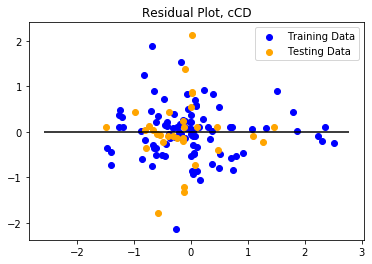

In [83]:
# RBF model is the best for cCD regression
# Plot cCD residuals based on RBF SVR model
model = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=0.1)
X_train_x = model.fit(X_train_scaled,y_train_array).predict(X_train_scaled)
X_test_x = model.fit(X_test_scaled,y_test_array).predict(X_test_scaled)
plt.scatter(X_train_x,X_train_x - y_train_array, c='blue',label='Training Data')
plt.scatter(X_test_x,X_test_x - y_test_array, c='orange', label='Testing Data')
plt.legend()
plt.hlines(y=0,xmin=y_train_array.min(),xmax=y_train_array.max())
plt.title('Residual Plot, cCD')
fig.set_size_inches(6, 4)
plt.show()

In [84]:
# Plot actual and predicted values
# Transform full set of data
X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y)
# Change y into terms that the SVR can use
y_ravel = y_scaled.ravel()
y_array = np.array(y_ravel).astype(float)

In [85]:
model = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=0.1)
# Inverse the transformation of y
y_predicted = y_scaler.inverse_transform((model.fit(X_scaled,y_array).predict(X_scaler.transform(X))))

In [86]:
monthly_pD['Predicted_cCD'] = y_predicted
monthly_pD['cCD_Error'] = monthly_pD['Predicted_cCD'] - monthly_pD['cCD_per_prod']
monthly_pD.head()

,year_month,average_exhaustion,average_sA,number_extract_points,average_pD,Predicted_pD,Error,datetime,cCD,production,cCD_per_prod,Predicted_cCD,cCD_Error
0,200908,45.33,0.243,152.0,0.017667,0.009233,-0.008434,2009-08-01,30000.0,667760,0.047209,0.048480,0.001271
1,200909,46.52,0.244,141.0,0.018667,0.009241,-0.009426,2009-09-01,30000.0,595958,0.050486,0.051895,0.001409
2,200910,42.35,0.241,174.0,0.015900,0.009169,-0.006731,2009-10-01,22500.0,497380,0.046846,0.042317,-0.004529
3,200911,37.27,0.242,215.0,0.016556,0.008799,-0.007757,2009-11-01,15000.0,405457,0.045036,0.041651,-0.003385
4,200912,35.62,0.243,201.0,0.016238,0.008584,-0.007654,2009-12-01,30000.0,610543,0.044602,0.039832,-0.004770


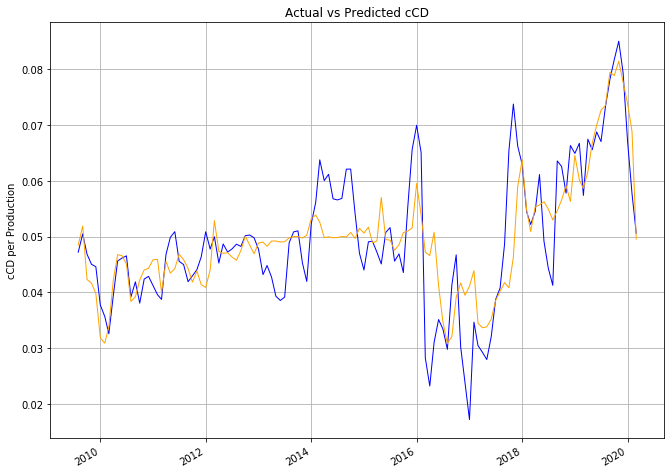

In [87]:
fig, ax1 = plt.subplots()
ax1.plot(monthly_pD['datetime'],monthly_pD['cCD_per_prod'],c='blue',linewidth = 1)
ax1.plot(monthly_pD['datetime'],monthly_pD['Predicted_cCD'],c='orange',linewidth = 1)
ax1.set_ylabel('cCD per Production')

fig.autofmt_xdate()
plt.grid(True)
plt.title('Actual vs Predicted cCD')
fig.set_size_inches(11, 8.5)
# fig.savefig('Images/monthly_pD_rbf.png', dpi=100)
plt.show()

In [88]:
print("MSE for the multivariate, RBF regression: "+str(mean_squared_error(monthly_pD['cCD_per_prod'],monthly_pD['Predicted_cCD'])))
print("the R2 Score for the multivariate, RBF regression: "+str(model.score(X_scaled,y_array)))

MSE for the multivariate, RBF regression: 5.782303770743504e-05
the R2 Score for the multivariate, RBF regression: 0.6264384776776513


In [89]:
monthly_pD.to_csv('Resources/monthly_pD_cCD.csv',index=False)